# Result viz for dpsk aime

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sal.utils.math import (
    find_majority_answer, extract_completion_answers,
    memoized_canonical_form, find_answer_with_largest_sum,
    strip_string
)

from tqdm import tqdm
from datasets import Dataset, load_dataset

import sys
sys.path.append('/root/tts_and_entropy')
from early_stopping_utils import choose_early_stop_point


def fine_line_with_max_token(reason_length, max_token=1024):
    """
    Find the line with the maximum token length that is less than or equal to max_token.
    """
    for i, length in enumerate(reason_length):
        if length > max_token:
            return i - 1
    return len(reason_length) - 1


def load_log(QID, acc_dir, entropy_dir, entropy_pattern, include_ans=False):
    tmp_dir = acc_dir
    entropy_base_dir = entropy_dir

    ACC = np.load(
        os.path.join(tmp_dir, f'all_accs_{QID}.npy')
    )

    ENTROPY = np.load(
        os.path.join(entropy_base_dir, entropy_pattern.format(QID))
    )

    if include_ans:
        ANS = np.load(
            os.path.join(tmp_dir, f'all_extracted_answers_{QID}.npy')
        )
        ua = []
        for _A in ANS:
            ua.append(len(np.unique(_A)))
        return ACC, ENTROPY, np.array(ua), ANS
    
    return ACC, ENTROPY


dataset_name = "opencompass/AIME2025"
dataset_split = "test"
dataset = load_dataset(dataset_name, 'AIME2025-I', split=dataset_split)
gt_answers = [
    row['answer']
    for row in dataset
]

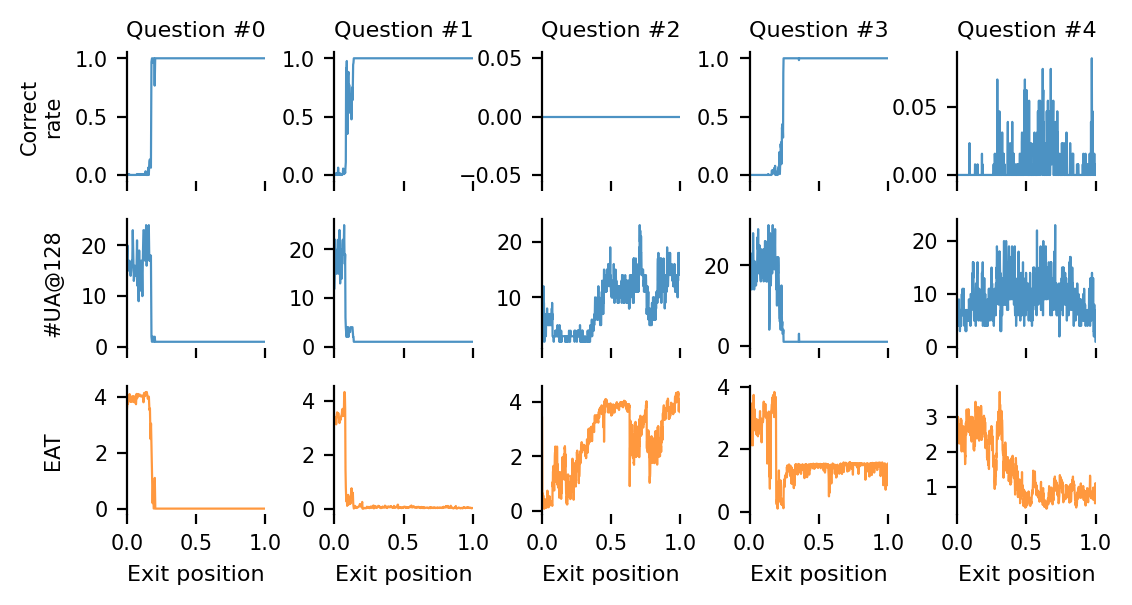

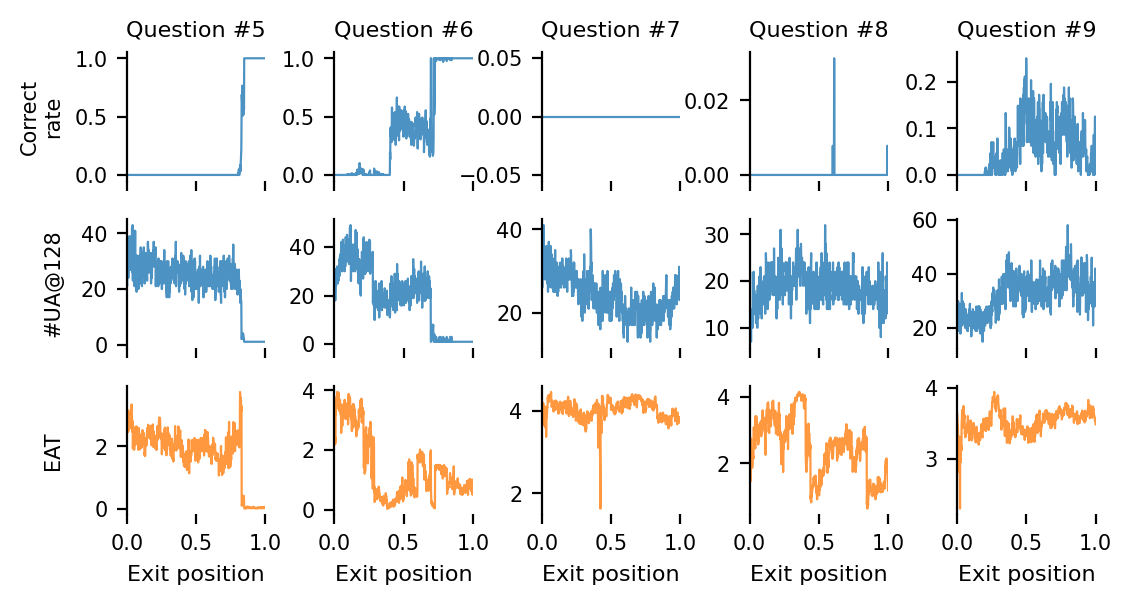

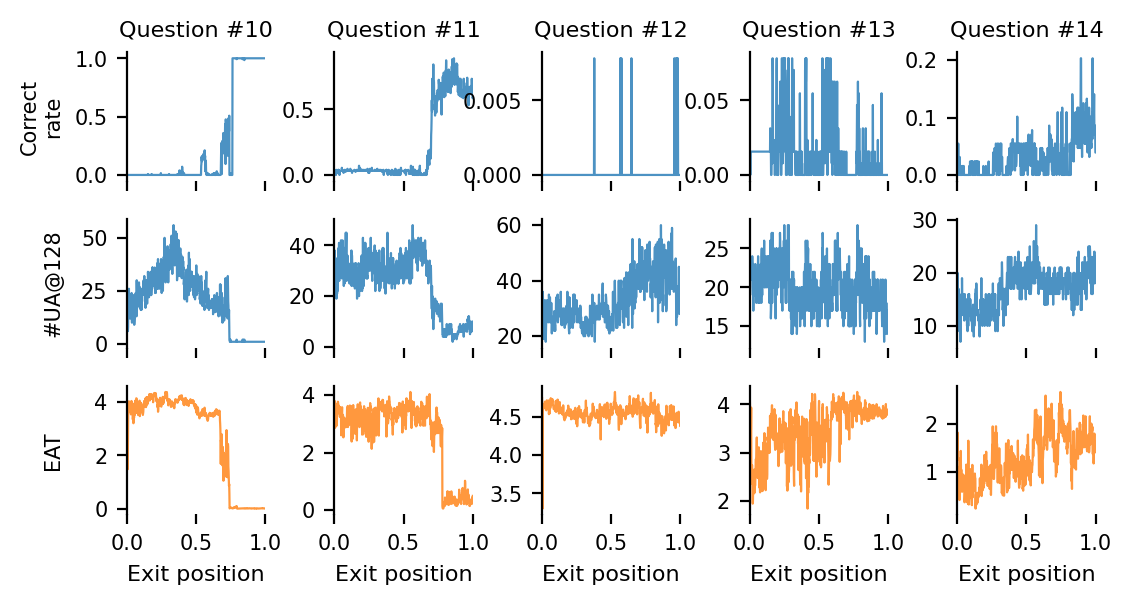

In [2]:
from matplotlib import cm
my_colors = cm.tab10([0,1,2,3])

for PART in [0, 1, 2]:

    QIDS = [
        0, 1, 2, 3, 4
    ]

    fig, ax = plt.subplots(3, len(QIDS), figsize=(6.25, 3.0), sharex='col')
    fig.subplots_adjust(wspace=0.5, hspace=0.3)
    line_config = {
        'linewidth': 0.8,
        'alpha': 0.8,
    }

    acc_dir = '/root/tts_and_entropy/outputs/cached_resultsaime2025_2_long_long'
    entropy_dir = '/root/tts_and_entropy/outputs/entropy_log_math'

    for i, a in enumerate(ax[0]):
        a.set_title(f'Question #{QIDS[i] + PART * 5}', fontsize=8)

    for a in ax.flatten():
        a.spines['top'].set_visible(False)
        a.spines['right'].set_visible(False)
        a.spines['bottom'].set_visible(False)
        a.tick_params(labelsize=7.5, axis='both')

    for a in ax[-1]:
        a.set_xlabel('Exit position', fontsize=8)
        a.set_xticks([0.0, 0.5, 1.0])
        a.set_xlim(0, 1.0)

    for i, qid in enumerate(QIDS):
        acc, ent, ua, ans = load_log(
                qid + PART * 5,
                acc_dir,
                entropy_dir,
                f'entropy_{qid + PART * 5}_new_dpsk_new_with_sample_ngram_with_final_answer_str_long_aime2025_2.npy',
                include_ans=True
            )

        X = np.arange(len(acc)) / (len(acc) - 1)

        ax[0, i].plot(X, acc, **line_config)
        ENT = ent[:, 1]
        X = np.arange(len(ENT)) / (len(ENT) - 1)
        ax[2, i].plot(X, ENT, label='unigram',
                    c=my_colors[1],
                    **line_config)
        X = np.arange(len(ua)) / (len(ua) - 1)
        ax[1, i].plot(X, ua, **line_config)


        if i == 0:
            ax[0, 0].set_ylabel('Correct\nrate', fontsize=7.5)
            ax[2, 0].set_ylabel('EAT', fontsize=7.5)
            ax[1, 0].set_ylabel('#UA@128', fontsize=7.5)


    fig.align_ylabels(ax[:, 0])

    # fig.savefig(
    #     f'/root/figures/aime_full_part_{PART}.pdf',
    #     bbox_inches='tight',
    # )

In [5]:
from transformers import AutoTokenizer
model_solutions_dir = "/root/tts_and_entropy/model_solutions/dpsk_new_with_sample_long_long_aime2025.json"
model_solutions_dir_2 = "/root/tts_and_entropy/model_solutions/dpsk_new_with_sample_long_long_aime2025_2.json"

MAX_RANGE = 15
# MAX_RANGE = 30

model_solutions = []
with open(model_solutions_dir, 'r') as f:
    for line in f:
        if line.strip():
            model_solutions.append(json.loads(line.strip()))

with open(model_solutions_dir_2, 'r') as f:
    for line in f:
        if line.strip():
            model_solutions.append(json.loads(line.strip()))

model_solutions = model_solutions[:MAX_RANGE]
reason_lengths = []
reason_number_of_lines = []

model_name = "deepseek-ai/DeepSeek-R1-0528-Qwen3-8B"
tokenizer = AutoTokenizer.from_pretrained(model_name)

for row in model_solutions:
    model_response = (row['response'])
    model_response = model_response.split('</think>')[0]
    # reasoning_line = model_response.split("<think>")[1].split('\n')[1::2]
    reasoning_line = model_response.split("<think>")[1].split('\n\n')
    # Extract reasoning length of each line
    reasoning_length = np.array([
        len(tokenizer(line)['input_ids']) for line in reasoning_line
    ])
    reasoning_length = np.cumsum(reasoning_length)
    reason_lengths.append(reasoning_length)

In [6]:
all_accs, all_entropy, all_unique_answers, all_extracted_answers = [], [], [], []
all_entropy_with_final_ans = []
all_entropy_with_final_ans_dpsk_small = []
acc_dir = '/root/tts_and_entropy/outputs/cached_results_dpsk_aime2025_long_long'
acc_dir_2 = '/root/tts_and_entropy/outputs/cached_resultsaime2025_2_long_long'

entropy_template = 'entropy_{}_new_dpsk_new_with_sample_ngram_with_final_answer_str_long_aime2025.npy'
entropy_template_2 = 'entropy_{}_new_dpsk_new_with_sample_ngram_long_aime2025.npy'
entropy_template_dpsk_small = 'entropy_{}_new_dpsk_new_with_sample_ngram_with_final_answer_str_long_aime2025_eatEvaluedBydpsk_small.npy'
entropy_template_dpsk_small_2 = 'entropy_{}_new_dpsk_new_with_sample_ngram_long_aime2025_eatEvaluedBydpsk_small.npy'
entropy_dir = '/root/tts_and_entropy/outputs/entropy_log_math'

for qid in tqdm(range(MAX_RANGE)):
    if qid < 15:
        _acc_dir = acc_dir
        _entropy_template = entropy_template
        _entropy_template_2 = entropy_template_2
        _entropy_template_dpsk_small = entropy_template_dpsk_small
        _entropy_template_dpsk_small_2 = entropy_template_dpsk_small_2
    else:
        qid = qid - 15
        _acc_dir = acc_dir_2
        _entropy_template = entropy_template.replace('aime2025', 'aime2025_2')
        _entropy_template_2 = entropy_template_2.replace('aime2025', 'aime2025_2')
        _entropy_template_dpsk_small = entropy_template_dpsk_small.replace('aime2025', 'aime2025_2')
        _entropy_template_dpsk_small_2 = entropy_template_dpsk_small_2.replace('aime2025', 'aime2025_2')
    acc, entropy, unique_answers, extracted_answers = load_log(
        qid,
        _acc_dir,
        entropy_dir,
        _entropy_template,
        include_ans=True
    )

    _, entropy_2 = load_log(
        qid,
        _acc_dir,
        entropy_dir,
        _entropy_template_2,
        include_ans=False
    )
    all_accs.append(acc)
    # all_entropy.append(entropy[:, 1])
    all_entropy.append((entropy[:, 1] + entropy_2[:, 1]) / 2)
    # all_entropy.append((entropy[:, 1] + entropy_2[:, 1]) / 2)
    all_unique_answers.append(unique_answers)
    all_extracted_answers.append(extracted_answers)

    acc, entropy_1 = load_log(
        qid,
        acc_dir,
        entropy_dir,
        _entropy_template_dpsk_small,
        include_ans=False
    )

    acc, entropy_2 = load_log(
        qid,
        acc_dir,
        entropy_dir,
        _entropy_template_dpsk_small_2,
        include_ans=False
    )

    all_entropy_with_final_ans_dpsk_small.append(
        (entropy_1[:, 1] + entropy_2[:, 1]) / 2
    )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [03:13<00:00, 12.93s/it]


In [11]:
max_token_budget = [
    500 * i for i in range(1, 41)
]

accs = []
total_tokens = []
token_usage = []

for budget in tqdm(max_token_budget):
    _accs = []
    _total_tokens = []
    for qid in range(MAX_RANGE):
        token_cost = reason_lengths[qid]
        acc = all_accs[qid]
        line_number = fine_line_with_max_token(token_cost, max_token=budget)
        _total_tokens.append(token_cost[line_number])
        _accs.append(acc[line_number])
    accs.append(_accs)
    total_tokens.append(np.sum(_total_tokens))
    token_usage.append(_total_tokens)

accs = np.array(accs)
total_tokens = np.array(total_tokens)
total_usage = np.array(token_usage)

results_opt = []
target_acc = np.arange(0.1, 1.02, 0.01)
accs_posthoc_acc = []
total_tokens_posthoc_acc = []
exit_idxes = []
for t in tqdm(target_acc):
    _accs = []
    _total_tokens = []
    for qid in range(MAX_RANGE):
        token_cost = reason_lengths[qid]
        acc = all_accs[qid]
        exit_idx = np.argmax([acc > t])
        if acc.max() < t:
            exit_idx = -1
            # exit_idx = acc.argmax()
        exit_idxes.append(exit_idx)
        _total_tokens.append(token_cost[exit_idx])
        if exit_idx == -1:
            _accs.append(acc.max())
        else:
            _accs.append(acc[exit_idx])
    accs_posthoc_acc.append(_accs)
    total_tokens_posthoc_acc.append(np.sum(_total_tokens))

accs_posthoc_acc = np.array(accs_posthoc_acc)
total_tokens_posthoc_acc = np.array(total_tokens_posthoc_acc)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:00<00:00, 6249.71it/s]


In [8]:
thresholds = np.array([1.5 ** (-i) for i in range(0, 80)])
accs_entropy_and_token = {}
total_tokens_entropy_and_token = {}
tokens_entropy_and_token = {}
EIDX = [1]
timescales = [0.015, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3]

for timescale in timescales:
    for eidx in EIDX:
        accs_entropy_and_token[(timescale, eidx)] = []
        total_tokens_entropy_and_token[(timescale, eidx)] = []
        tokens_entropy_and_token[(timescale, eidx)] = []
        for t in tqdm(thresholds):
            _accs = []
            _total_tokens = []
            for qid in range(MAX_RANGE):
                token_cost = reason_lengths[qid]

                acc, entropy = all_accs[qid], all_entropy[qid][:]
                exit_idx = fine_line_with_max_token(token_cost, max_token=20000)

                exit_idx_entropy = choose_early_stop_point(entropy, timescale, t, 120, min_value_threshold=None, normalize=False) 
                
                if exit_idx_entropy == -1 or exit_idx_entropy > exit_idx:
                    exit_idx_entropy = exit_idx
                _total_tokens.append(token_cost[exit_idx_entropy])
                _accs.append(acc[exit_idx_entropy])
            accs_entropy_and_token[(timescale, eidx)].append(_accs)
            total_tokens_entropy_and_token[(timescale, eidx)].append(np.sum(_total_tokens))
            tokens_entropy_and_token[(timescale, eidx)].append(_total_tokens)

        accs_entropy_and_token[(timescale, eidx)] = np.array(accs_entropy_and_token[(timescale, eidx)]).reshape(len(thresholds), MAX_RANGE)
        total_tokens_entropy_and_token[(timescale, eidx)] = np.array(total_tokens_entropy_and_token[(timescale, eidx)]).reshape(len(thresholds))
        tokens_entropy_and_token[(timescale, eidx)] = np.array(tokens_entropy_and_token[(timescale, eidx)]).reshape(len(thresholds), MAX_RANGE)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 86.81it/s]


In [9]:
thresholds = np.array([1.5 ** (-i) for i in range(0, 80)])
EIDX = [2]
# timescales = [0.05, 0.075, 0.1, 0.15, 0.2, 0.3]
timescales = [0.015, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3]

for timescale in timescales:
    for eidx in EIDX:
        accs_entropy_and_token[(timescale, eidx)] = []
        total_tokens_entropy_and_token[(timescale, eidx)] = []
        tokens_entropy_and_token[(timescale, eidx)] = []
        for t in tqdm(thresholds):
            _accs = []
            _total_tokens = []
            for qid in range(MAX_RANGE):
                token_cost = reason_lengths[qid]

                # acc, entropy = all_accs[qid], all_entropy_with_final_ans_dpsk_small[qid][:, 1]
                acc, entropy = all_accs[qid], all_entropy_with_final_ans_dpsk_small[qid][:]
                exit_idx = fine_line_with_max_token(token_cost, max_token=20000)

                exit_idx_entropy = choose_early_stop_point(entropy, timescale, t, 120, min_value_threshold=None, normalize=False) 
                
                if exit_idx_entropy == -1 or exit_idx_entropy > exit_idx:
                    exit_idx_entropy = exit_idx
                _total_tokens.append(token_cost[exit_idx_entropy])
                _accs.append(acc[exit_idx_entropy])
            accs_entropy_and_token[(timescale, eidx)].append(_accs)
            total_tokens_entropy_and_token[(timescale, eidx)].append(np.sum(_total_tokens))
            tokens_entropy_and_token[(timescale, eidx)].append(_total_tokens)

        accs_entropy_and_token[(timescale, eidx)] = np.array(accs_entropy_and_token[(timescale, eidx)]).reshape(len(thresholds), MAX_RANGE)
        total_tokens_entropy_and_token[(timescale, eidx)] = np.array(total_tokens_entropy_and_token[(timescale, eidx)]).reshape(len(thresholds))
        tokens_entropy_and_token[(timescale, eidx)] = np.array(tokens_entropy_and_token[(timescale, eidx)]).reshape(len(thresholds), MAX_RANGE)

  0%|                                                                                                                                                         | 0/80 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 86.52it/s]


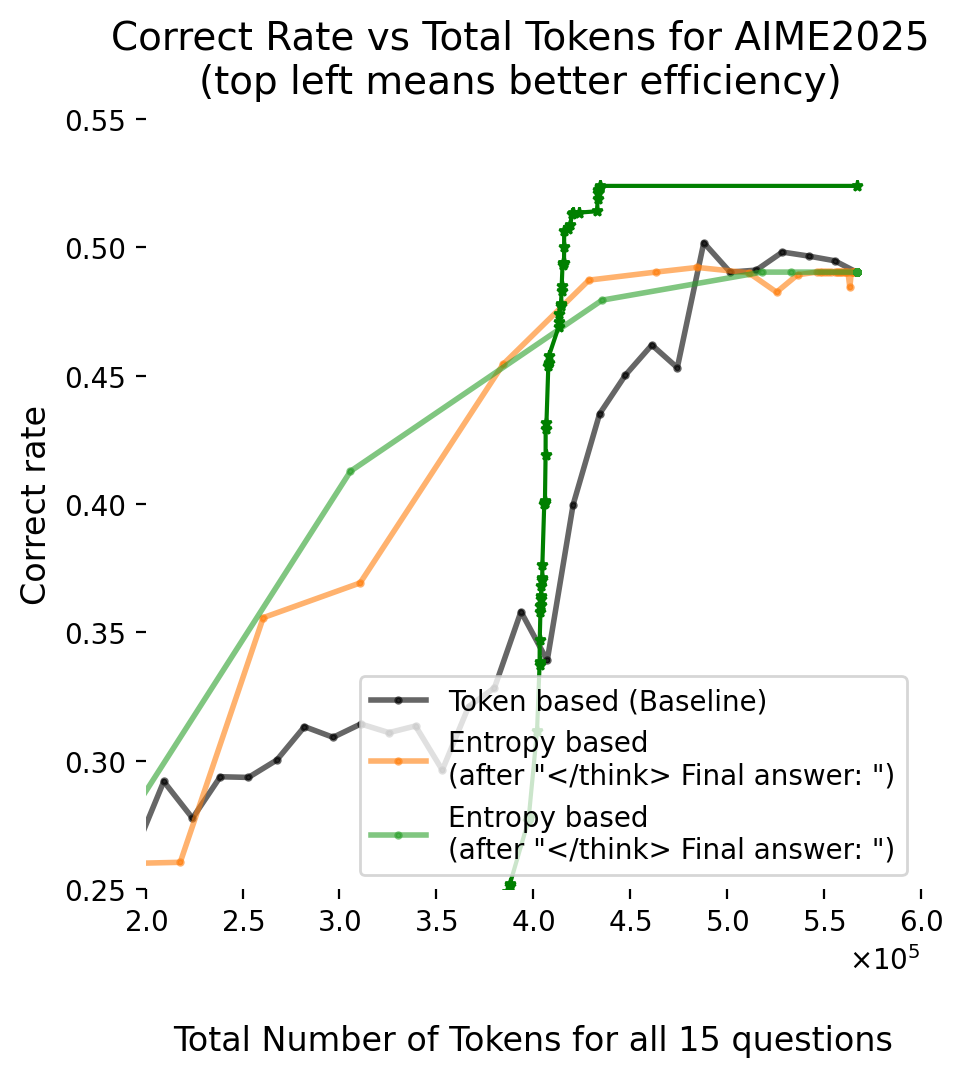

In [694]:
import matplotlib.ticker as mticker
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
from matplotlib import cm
my_colors = cm.tab10([0,1,2,3])

line_config = {
    'linestyle': '-',
    'marker': 'o',
    'markersize': 2,
    'linewidth': 2.0,
    'alpha': 0.6
}

ax.plot(total_tokens, accs.mean(1), label='Token based (Baseline)', color='black',
    **line_config)


TT = total_tokens_entropy_and_token[(0.025, 1)]
ACC = accs_entropy_and_token[(0.025, 1)]

ax.plot(TT, ACC.mean(1), label='Entropy based\n(after "</think> Final answer: ")', c=my_colors[1],
        **line_config)

TT = total_tokens_entropy_and_token[(0.075, 2)]
ACC = accs_entropy_and_token[(0.075, 2)]

ax.plot(TT, ACC.mean(1), label='Entropy based\n(after "</think> Final answer: ")', c=my_colors[2],
        **line_config)

ax.set_xlim(2e5, 6e5)
ax.set_ylim(0.25, 0.55)

ax.legend()

ax.set_xlabel('\n\nTotal Number of Tokens for all 15 questions', fontsize=12)
ax.set_ylabel('Correct rate', fontsize=12)

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
ax.get_xaxis().get_offset_text().set_fontsize(10)

fig.suptitle('Correct Rate vs Total Tokens for AIME2025\n(top left means better efficiency)', fontsize=14)

post_hoc_best_result = {}
for c, a in zip(total_tokens_posthoc_acc, accs_posthoc_acc.mean(1)):
    if c not in post_hoc_best_result:
        post_hoc_best_result[c] = a
    else:
        post_hoc_best_result[c] = max(a, post_hoc_best_result[c])

ax.plot(list(post_hoc_best_result.keys()), list(post_hoc_best_result.values()), label='Post-hoc Acc based', color='green', marker='*', markersize=4, linewidth=1.5)

# Hide frame
for spine in ax.spines.values():
    spine.set_visible(False)

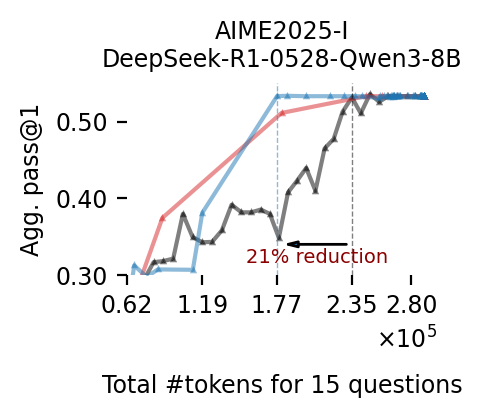

In [15]:
import matplotlib.ticker as mticker
fig, ax = plt.subplots(figsize=(2.0, 2.0))
from matplotlib import cm
my_colors = cm.tab10([0,1,2,3])

FONT_SIZE = 8.5

line_config = {
    'marker': '^',
    'markersize': 1, 'linewidth': 1.5,
    'alpha': 0.5
}

ax.plot(total_tokens, accs.mean(1), color='black',
    **line_config)


TT_dpsk_small = total_tokens_entropy_and_token[(0.075, 2)]
ACC_dpsk_small = accs_entropy_and_token[(0.075, 2)]


TT_dpsk_new = total_tokens_entropy_and_token[(0.075, 1)]
ACC_dpsk_new = accs_entropy_and_token[(0.075, 1)]

ax.plot(TT_dpsk_small, ACC_dpsk_small.mean(1), c=my_colors[3],
        # linestyle='--',
        **line_config)

ax.plot(TT_dpsk_new, ACC_dpsk_new.mean(1), c=my_colors[0],
        linestyle='-',
        **line_config)

ax.set_xlim(.8e5, 3e5)
ax.set_ylim(0.3, 0.55)

def two_decimal_places(x, pos):
    return f'{x:.2f}'
ax.yaxis.set_major_formatter(mticker.FuncFormatter(two_decimal_places))


class ScalarFormatterForceFormat(mticker.ScalarFormatter):
    def _set_format(self):  # Override function that finds format to use.
        self.format = "%1.2f"  # Give format here

formatter = ScalarFormatterForceFormat(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
ax.get_xaxis().get_offset_text().set_fontsize(FONT_SIZE)
ax.tick_params(axis='both', labelsize=FONT_SIZE)
ax.set_ylabel('Agg. pass@1', fontsize=FONT_SIZE)
ax.set_xlabel('Total #tokens for 15 questions', fontsize=FONT_SIZE, labelpad=20.0)
ax.set_title('AIME2025-I\nDeepSeek-R1-0528-Qwen3-8B', fontsize=FONT_SIZE)

ax.set_box_aspect(0.618)

for spine in ax.spines.values():
    spine.set_visible(False)


blue_line_idx = TT_dpsk_new[np.argmax(ACC_dpsk_new.mean(1) > 0.52)]
ax.axvline(blue_line_idx, color=my_colors[0], linestyle='--', linewidth=.5, alpha=0.5)

black_line_idx = total_tokens[np.argmax(accs.mean(1) > 0.52)]
ax.axvline(black_line_idx, color='black', linestyle='--', linewidth=.5, alpha=0.5)

y_target = 0.34

import matplotlib.patches as mpatches
arr = mpatches.FancyArrowPatch((black_line_idx, y_target), (blue_line_idx, y_target),
                               arrowstyle='-|>,head_width=.1',
                            # arrowstyle='simple',
                               mutation_scale=9)
ax.add_patch(arr)
ax.annotate("21% reduction",
    (.5, -4.0), xycoords=arr, ha='center', va='bottom',
    fontsize=7, color='darkred')

GAP_SIZE = black_line_idx - blue_line_idx
ax.set_xticks([
    blue_line_idx - 2 * GAP_SIZE,
    blue_line_idx - GAP_SIZE,
    blue_line_idx, black_line_idx, 2.8e5])


fig.savefig('/root/figures/aime_qwen3-8b.pdf', bbox_inches='tight')

In [718]:
(2.3 - 1.8) / 2.3

0.217391304347826